In [2]:
import numpy as np
import dedalus.public as d3
import dedalus.core as d4
import logging
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline
import pathlib
import subprocess
import h5py
import glob

In [9]:
"""
Dedalus script simulating 2D horizontally-periodic Rayleigh-Benard convection.
This script demonstrates solving a 2D Cartesian initial value problem. It can
be ran serially or in parallel, and uses the built-in analysis framework to save
data snapshots to HDF5 files. The `plot_snapshots.py` script can be used to
produce plots from the saved data. It should take about 5 cpu-minutes to run.

The problem is non-dimensionalized using the box height and freefall time, so
the resulting thermal diffusivity and viscosity are related to the Prandtl
and Rayleigh numbers as:

    kappa = (Rayleigh * Prandtl)**(-1/2)
    nu = (Rayleigh / Prandtl)**(-1/2)

For incompressible hydro with two boundaries, we need two tau terms for each the
velocity and buoyancy. Here we choose to use a first-order formulation, putting
one tau term each on auxiliary first-order gradient variables and the others in
the PDE, and lifting them all to the first derivative basis. This formulation puts
a tau term in the divergence constraint, as required for this geometry.

To run and plot using e.g. 4 processes:
    $ mpiexec -n 4 python3 rayleigh_benard.py
    $ mpiexec -n 4 python3 plot_snapshots.py snapshots/*.h5
"""

logger = logging.getLogger(__name__)


# Parameters
Lx, Ly, Lz = 4, 4, 1
Nx, Ny, Nz = 128, 128, 32
Md = 3
Rayleigh = 1e6
Vaisala= 4
Prandtl = 0.7
dealias = 3/2
stop_sim_time = 50
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x', 'y', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
ybasis = d3.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis, ybasis, zbasis))
d = dist.Field(name='d', bases=(xbasis, ybasis, zbasis))
m = dist.Field(name='m', bases=(xbasis, ybasis, zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis, ybasis, zbasis))
tau_p = dist.Field(name='tau_p')
tau_d1 = dist.Field(name='tau_d1', bases=(xbasis,ybasis))
tau_d2 = dist.Field(name='tau_d2', bases=(xbasis, ybasis))
tau_m1 = dist.Field(name='tau_m1', bases=(xbasis, ybasis))
tau_m2 = dist.Field(name='tau_m2', bases=(xbasis, ybasis))
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=(xbasis, ybasis))
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=(xbasis, ybasis))

# Substitutions
kappa = (Lz**3*Md)/(Rayleigh * Prandtl)**(1/2)
nu = (Lz**3*Md)/(Rayleigh / Prandtl)**(1/2)
x, y, z = dist.local_grids(xbasis, ybasis, zbasis)
ex, ey, ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
grad_d = d3.grad(d) + ez*lift(tau_d1) # First-order reduction
grad_m = d3.grad(m) + ez*lift(tau_m1) # First-order reduction
ncc = dist.Field(name='ncc', bases=zbasis)
ncc['g'] = z
ncc.change_scales(3/2)
B = (m+d-Vaisala*ncc+np.absolute(m-d+Vaisala*ncc))/2
u_x = u @ ex
u_y = u @ ey
u_z = u @ ez
dz = lambda A: d3.Differentiate(A, coords['z'])
integ = lambda A: d3.Integrate(A, coords)
integ1= lambda A: d3.Integrate(A, coords)

# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, d, m, u, tau_p, tau_d1, tau_d2, tau_m1, tau_m2, tau_u1, tau_u2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("dt(d) - kappa*div(grad_d) + lift(tau_d2) = - u@grad(d)")
problem.add_equation("dt(m) - kappa*div(grad_m) + lift(tau_m2) = - u@grad(m)")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p) + lift(tau_u2) = - u@grad(u)+ B*ez ")
problem.add_equation("d(z=0) = 0")
problem.add_equation("m(z=0) = 0")
problem.add_equation("d(z=Lz) = 1")
problem.add_equation("m(z=Lz) = -3")
problem.add_equation("u_z(z=0) = 0")
problem.add_equation("u_z(z=Lz) = 0")
problem.add_equation("dz(u_x)(z=0) = 0")
problem.add_equation("dz(u_x)(z=Lz)= 0")
problem.add_equation("dz(u_y)(z=0) = 0")
problem.add_equation("dz(u_y)(z=Lz)= 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Initial conditions
d.fill_random('g', seed=23, distribution='normal', scale=1e-3) # Random noise
d['g'] *= z * (Lz - z) # Damp noise at walls
d['g'] += z # Add linear background
m.fill_random('g', seed=41, distribution='normal', scale=1e-3) # Random noise
m['g'] *= z * (Lz - z) # Damp noise at walls
m['g'] += -3 * z # Add linear background

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=0.25, max_writes=50)
snapshots.add_task(d, name='dry buoyancy')
snapshots.add_task(m, name='moist buoyancy')
snapshots.add_task(B, name='buoyancy')
snapshots.add_task(B-d+Vaisala*ncc, name='additional buoyancy')
snapshots.add_task(0.5*d3.dot(u,u), name='KE')
snapshots.add_task(integ1(0.5*d3.dot(u,u)), name='total KE')

# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')

# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            #logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()


2023-06-14 15:33:25,318 subsystems 0/1 INFO :: Building subproblem matrices 1/4096 (~0%) Elapsed: 0s, Remaining: 28m 13s, Rate: 2.4e+00/s
2023-06-14 15:33:35,118 subsystems 0/1 INFO :: Building subproblem matrices 46/4096 (~1%) Elapsed: 10s, Remaining: 14m 59s, Rate: 4.5e+00/s
2023-06-14 15:33:44,973 subsystems 0/1 INFO :: Building subproblem matrices 90/4096 (~2%) Elapsed: 20s, Remaining: 14m 53s, Rate: 4.5e+00/s
2023-06-14 15:33:54,910 subsystems 0/1 INFO :: Building subproblem matrices 135/4096 (~3%) Elapsed: 30s, Remaining: 14m 40s, Rate: 4.5e+00/s
2023-06-14 15:34:05,033 subsystems 0/1 INFO :: Building subproblem matrices 181/4096 (~4%) Elapsed: 40s, Remaining: 14m 28s, Rate: 4.5e+00/s
2023-06-14 15:34:14,932 subsystems 0/1 INFO :: Building subproblem matrices 226/4096 (~6%) Elapsed: 50s, Remaining: 14m 17s, Rate: 4.5e+00/s
2023-06-14 15:34:25,052 subsystems 0/1 INFO :: Building subproblem matrices 272/4096 (~7%) Elapsed: 1m 00s, Remaining: 14m 06s, Rate: 4.5e+00/s
2023-06-14 15:3

2023-06-14 15:42:04,930 subsystems 0/1 INFO :: Building subproblem matrices 2343/4096 (~57%) Elapsed: 8m 40s, Remaining: 6m 29s, Rate: 4.5e+00/s
2023-06-14 15:42:14,967 subsystems 0/1 INFO :: Building subproblem matrices 2388/4096 (~58%) Elapsed: 8m 50s, Remaining: 6m 19s, Rate: 4.5e+00/s
2023-06-14 15:42:24,914 subsystems 0/1 INFO :: Building subproblem matrices 2433/4096 (~59%) Elapsed: 9m 00s, Remaining: 6m 09s, Rate: 4.5e+00/s
2023-06-14 15:42:30,893 subsystems 0/1 INFO :: Building subproblem matrices 2460/4096 (~60%) Elapsed: 9m 06s, Remaining: 6m 03s, Rate: 4.5e+00/s
2023-06-14 15:42:34,915 subsystems 0/1 INFO :: Building subproblem matrices 2478/4096 (~60%) Elapsed: 9m 10s, Remaining: 5m 59s, Rate: 4.5e+00/s
2023-06-14 15:42:44,957 subsystems 0/1 INFO :: Building subproblem matrices 2523/4096 (~62%) Elapsed: 9m 20s, Remaining: 5m 49s, Rate: 4.5e+00/s
2023-06-14 15:42:54,922 subsystems 0/1 INFO :: Building subproblem matrices 2568/4096 (~63%) Elapsed: 9m 30s, Remaining: 5m 39s, R

In [17]:
print(subprocess.check_output("find snapshots | sort",shell=True).decode())

OSError: [Errno 12] Cannot allocate memory

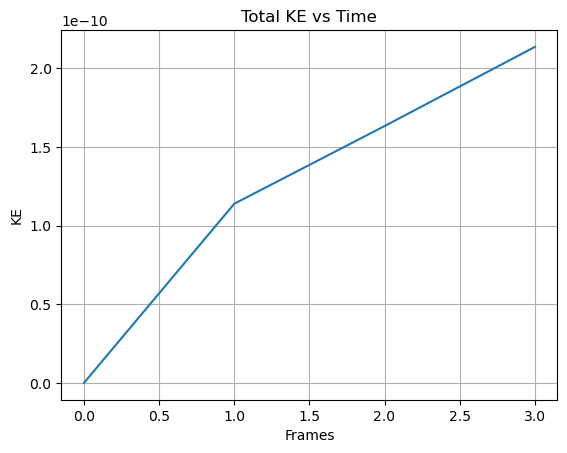

In [11]:
files = sorted(glob.glob('snapshots/*.h5'))
fig, ax = plt.subplots()

with h5py.File(files[0], mode='r') as file:
    KEs = file['tasks']['total KE'][:,:,:,:]
    
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        KE = file['tasks']['total KE'][:,:,:,:]
        KEs=np.append(KEs,KE,axis=0)

ax.plot(np.arange(len(KEs[:,0,0,0])), KEs[:,0,0,0])

ax.set_title('Total KE vs Time')
ax.grid(True)
ax.set_xlabel('Frames')
ax.set_ylabel('KE')

plt.savefig('Total_KE_vs_Time')

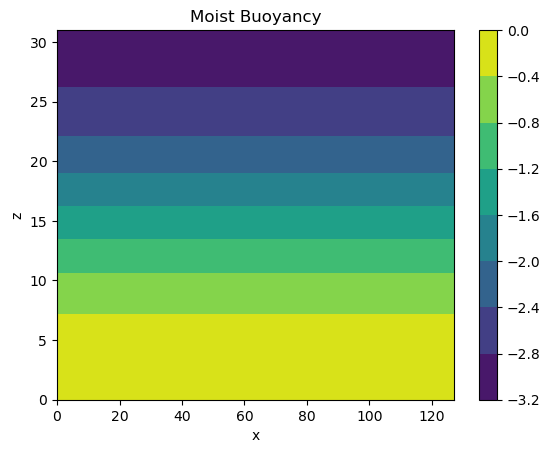

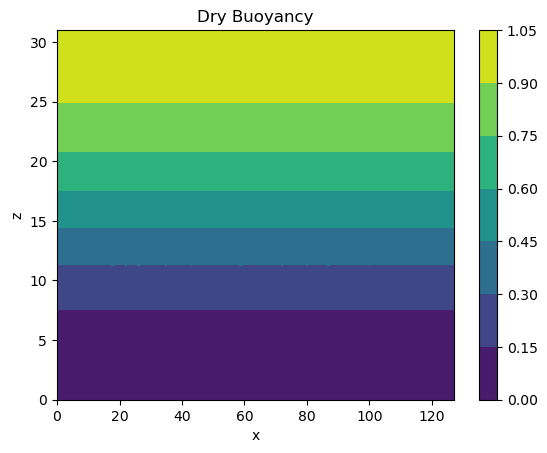

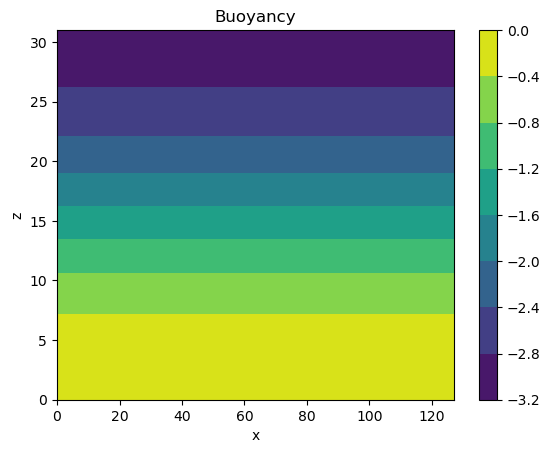

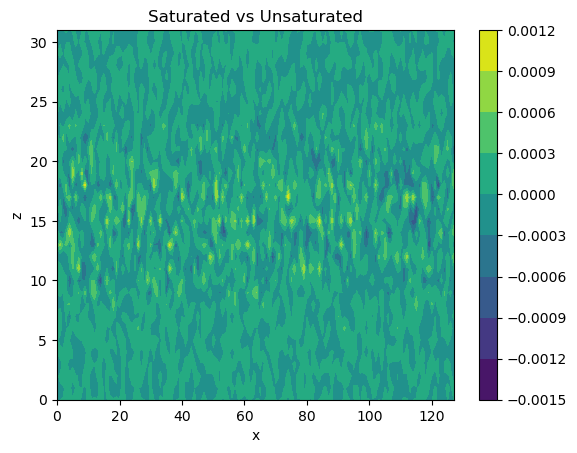

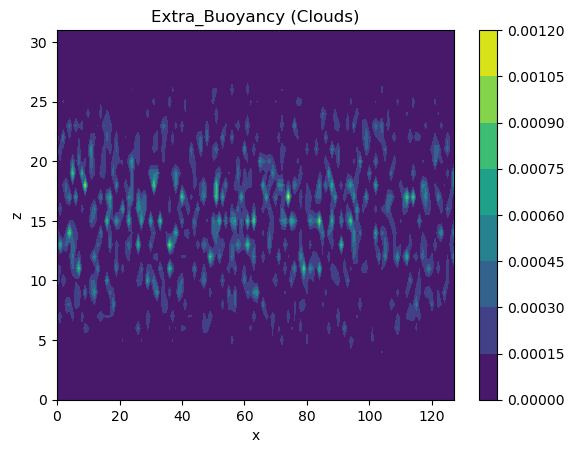

In [13]:
with h5py.File('snapshots/snapshots_s1.h5', 'r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy'][:, :, :,:] 
    dry_buoyancy = file['tasks']['dry buoyancy'][:, :, :,:]
    buoyancy=np.maximum(moist_buoyancy,dry_buoyancy-Vaisala*z)
    saturation=moist_buoyancy-dry_buoyancy+Vaisala*z
    extra_buoyancy=buoyancy-(dry_buoyancy-Vaisala*z)

    
    # Plotting moist buoyancy
    plt.figure()
    plt.contourf(np.arange(len(moist_buoyancy[-1, :, int(Ny/2), 1])), np.arange(len(z[0,0,:])), moist_buoyancy[0,:,int(Ny/2),:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Moist Buoyancy')
    plt.show()
    
    # Plotting dry buoyancy
    plt.figure()
    plt.contourf(np.arange(len(dry_buoyancy[-1, :, int(Ny/2), 1])), np.arange(len(z[0,0,:])), dry_buoyancy[0,:,int(Ny/2),:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Dry Buoyancy')
    plt.show()
    
    # Plotting buoyancy
    plt.figure()
    plt.contourf(np.arange(len(buoyancy[-1, :, int(Ny/2), 1])), np.arange(len(z[0,0,:])), buoyancy[0,:,int(Ny/2),:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Buoyancy')
    plt.show()
    
    # Plotting saturated region
    plt.figure()
    plt.contourf(np.arange(len(saturation[-1, :, int(Ny/2), 1])), np.arange(len(z[0,0,:])), saturation[0,:,int(Ny/2),:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Saturated vs Unsaturated')
    plt.show()
    

    # Plotting extra buoyancy
    plt.figure()
    plt.contourf(np.arange(len(extra_buoyancy[-1, :, int(Ny/2), 1])), np.arange(len(z[0,0,:])), extra_buoyancy[0,:,int(Ny/2),:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Extra_Buoyancy (Clouds)')
    plt.show()

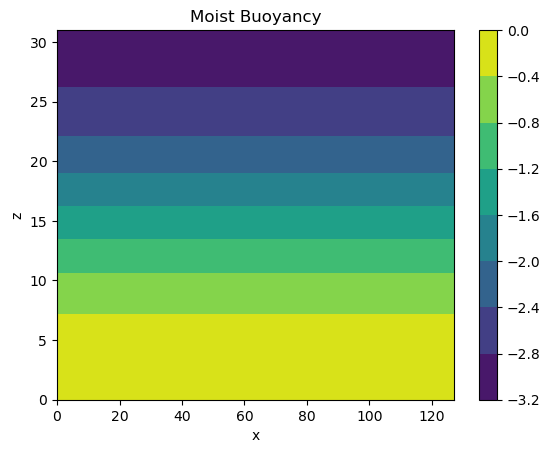

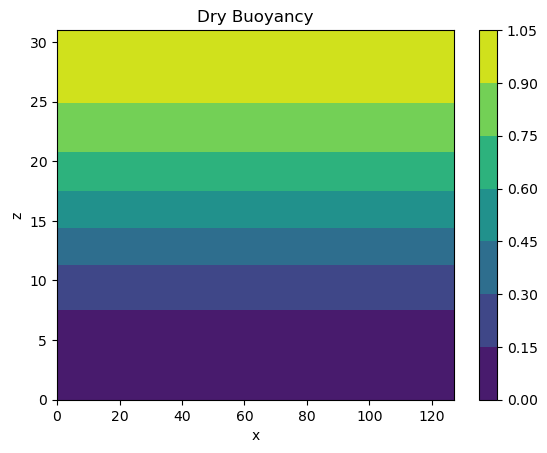

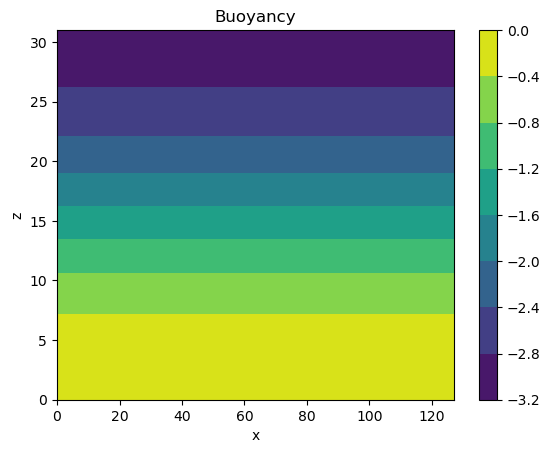

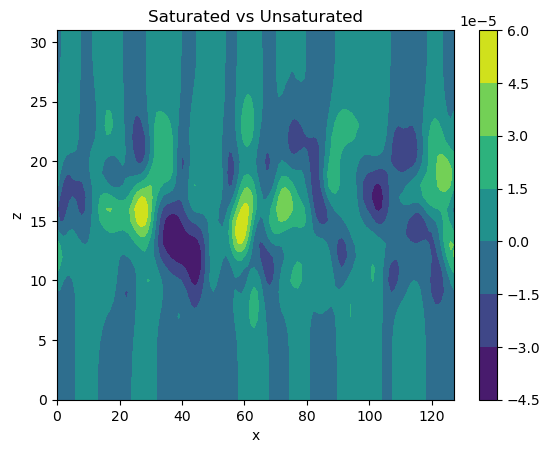

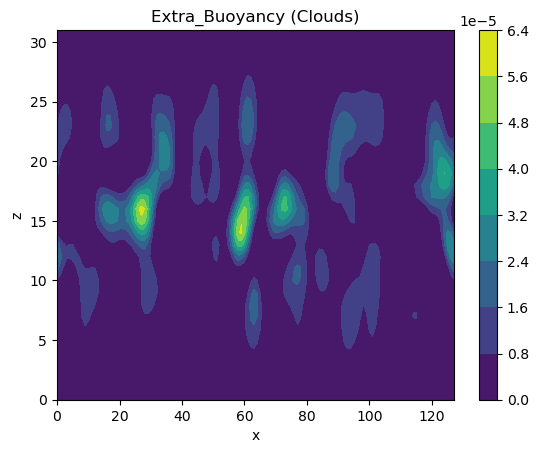

In [14]:
with h5py.File('snapshots/snapshots_s1.h5', 'r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy'][:, :, :,:] 
    dry_buoyancy = file['tasks']['dry buoyancy'][:, :, :,:]
    buoyancy=np.maximum(moist_buoyancy,dry_buoyancy-Vaisala*z)
    saturation=moist_buoyancy-dry_buoyancy+Vaisala*z
    extra_buoyancy=buoyancy-(dry_buoyancy-Vaisala*z)

    
    # Plotting moist buoyancy
    plt.figure()
    plt.contourf(np.arange(len(moist_buoyancy[-1, :, int(Ny/2), 1])), np.arange(len(z[0,0,:])), moist_buoyancy[-1,:,int(Ny/2),:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Moist Buoyancy')
    plt.show()
    
    # Plotting dry buoyancy
    plt.figure()
    plt.contourf(np.arange(len(dry_buoyancy[-1, :, int(Ny/2), 1])), np.arange(len(z[0,0,:])), dry_buoyancy[-1,:,int(Ny/2),:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Dry Buoyancy')
    plt.show()
    
    # Plotting buoyancy
    plt.figure()
    plt.contourf(np.arange(len(buoyancy[-1, :, int(Ny/2), 1])), np.arange(len(z[0,0,:])), buoyancy[-1,:,int(Ny/2),:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Buoyancy')
    plt.show()
    
    # Plotting saturated region
    plt.figure()
    plt.contourf(np.arange(len(saturation[-1, :, int(Ny/2), 1])), np.arange(len(z[0,0,:])), saturation[-1,:,int(Ny/2),:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Saturated vs Unsaturated')
    plt.show()
    

    # Plotting extra buoyancy
    plt.figure()
    plt.contourf(np.arange(len(extra_buoyancy[-1, :, int(Ny/2), 1])), np.arange(len(z[0,0,:])), extra_buoyancy[-1,:,int(Ny/2),:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Extra_Buoyancy (Clouds)')
    plt.show()

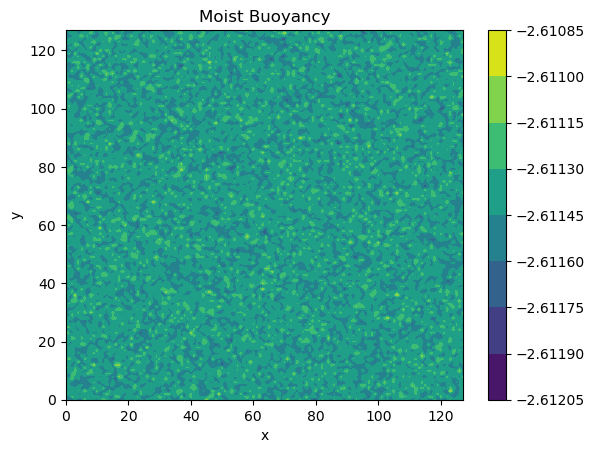

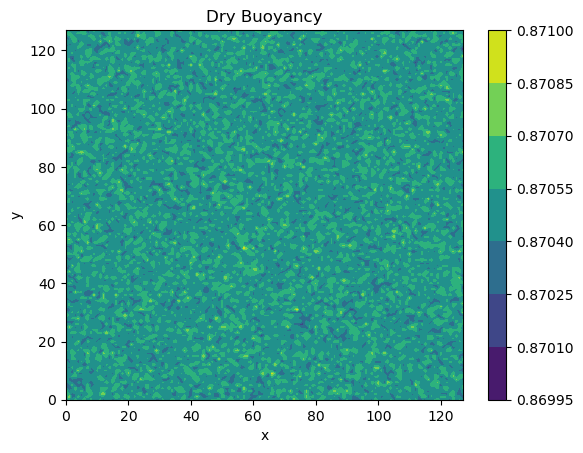

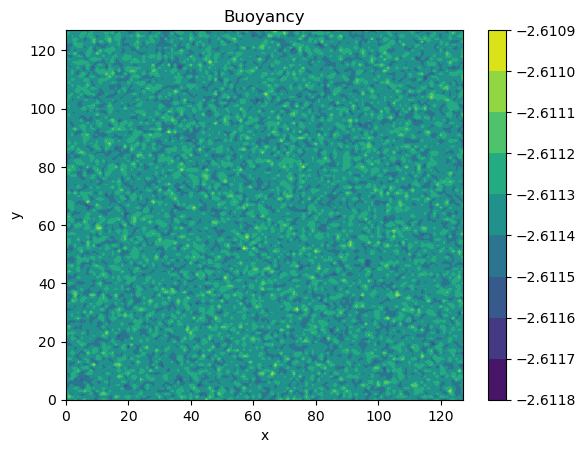

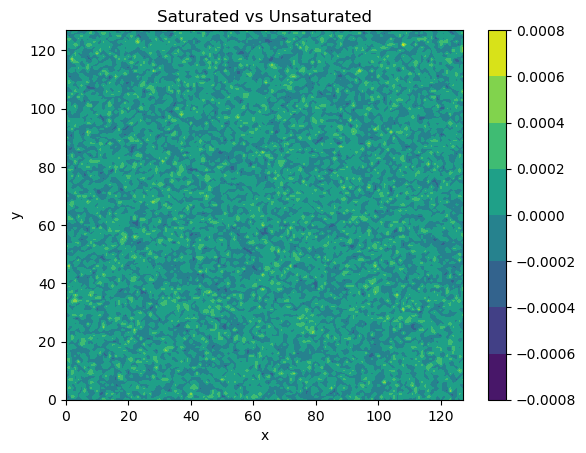

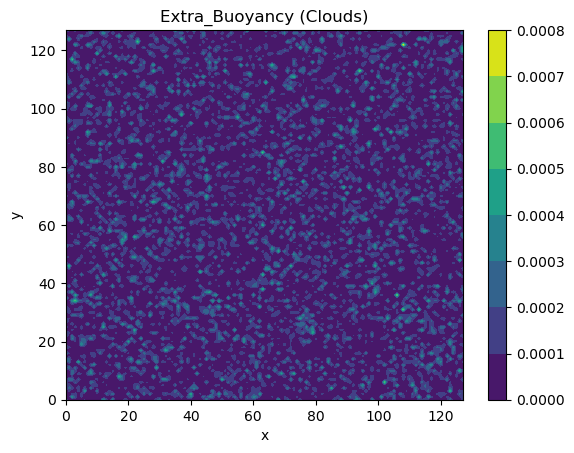

In [18]:
with h5py.File('snapshots/snapshots_s1.h5', 'r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy'][:, :, :,:] 
    dry_buoyancy = file['tasks']['dry buoyancy'][:, :, :,:]
    buoyancy=np.maximum(moist_buoyancy,dry_buoyancy-Vaisala*z)
    saturation=moist_buoyancy-dry_buoyancy+Vaisala*z
    extra_buoyancy=buoyancy-(dry_buoyancy-Vaisala*z)

    
    # Plotting moist buoyancy
    plt.figure()
    plt.contourf(np.arange(len(moist_buoyancy[-1, :, 0, 1])), np.arange(len(moist_buoyancy[-1, 0, :, 1])), moist_buoyancy[0,:,:,int(3*Nz/4)].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Moist Buoyancy')
    plt.show()
    
    # Plotting dry buoyancy
    plt.figure()
    plt.contourf(np.arange(len(dry_buoyancy[-1, :, 0, 1])), np.arange(len(dry_buoyancy[-1, 0, :, 1])), dry_buoyancy[0,:,:,int(3*Nz/4)].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Dry Buoyancy')
    plt.show()
    
    # Plotting buoyancy
    plt.figure()
    plt.contourf(np.arange(len(buoyancy[-1, :, 0, 1])), np.arange(len(buoyancy[-1, 0, :, 1])), buoyancy[0,:,:,int(3*Nz/4)].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Buoyancy')
    plt.show()
    
    # Plotting saturated region
    plt.figure()
    plt.contourf(np.arange(len(saturation[-1, :, 0, 1])), np.arange(len(saturation[-1, 0, :, 1])), saturation[0,:,:,int(3*Nz/4)].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Saturated vs Unsaturated')
    plt.show()
    

    # Plotting extra buoyancy
    plt.figure()
    plt.contourf(np.arange(len(extra_buoyancy[-1, :, 0, 1])), np.arange(len(extra_buoyancy[-1, 0, :, 1])), extra_buoyancy[0,:,:,int(3*Nz/4)].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Extra_Buoyancy (Clouds)')
    plt.show()

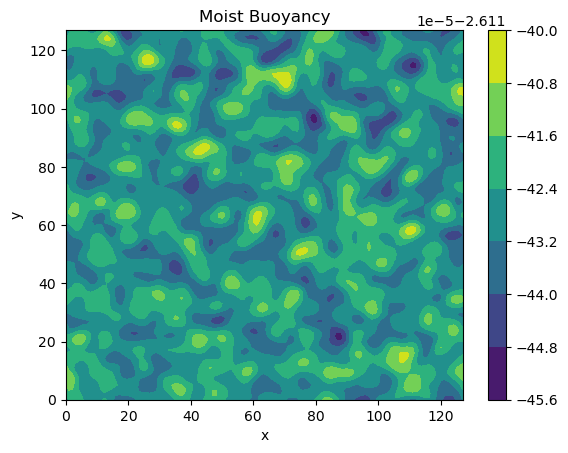

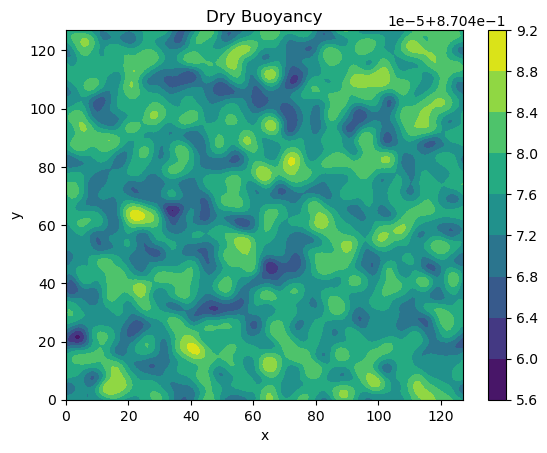

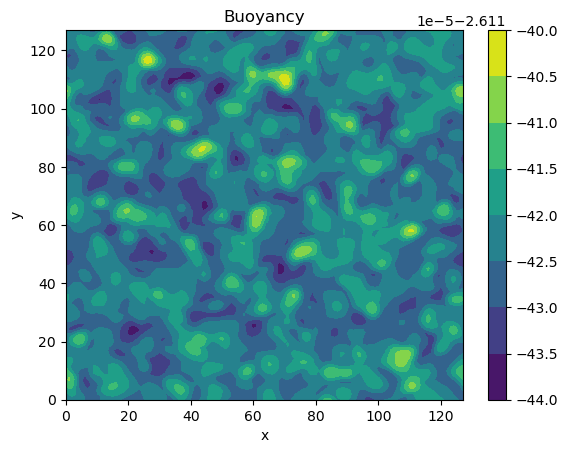

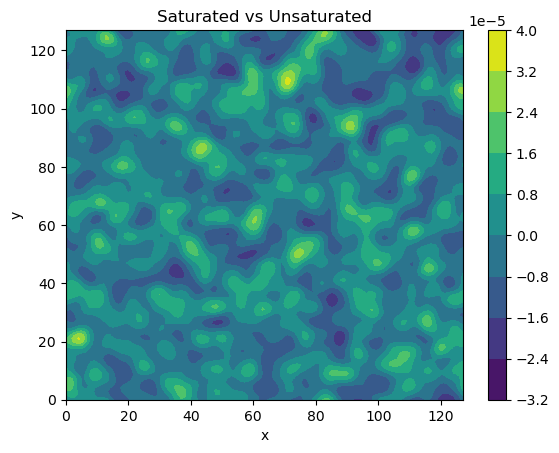

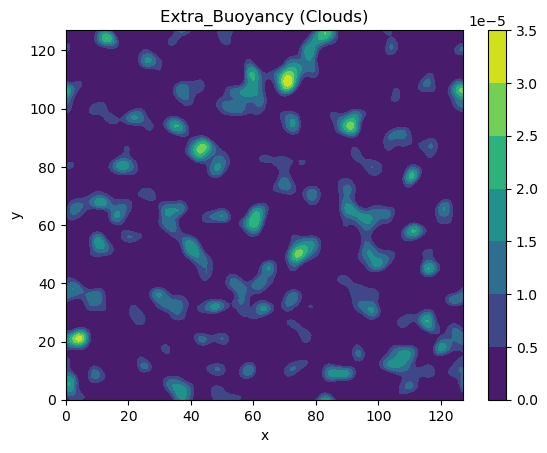

In [19]:
with h5py.File('snapshots/snapshots_s1.h5', 'r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy'][:, :, :,:] 
    dry_buoyancy = file['tasks']['dry buoyancy'][:, :, :,:]
    buoyancy=np.maximum(moist_buoyancy,dry_buoyancy-Vaisala*z)
    saturation=moist_buoyancy-dry_buoyancy+Vaisala*z
    extra_buoyancy=buoyancy-(dry_buoyancy-Vaisala*z)

    
    # Plotting moist buoyancy
    plt.figure()
    plt.contourf(np.arange(len(moist_buoyancy[-1, :, 0, 1])), np.arange(len(moist_buoyancy[-1, 0, :, 1])), moist_buoyancy[-1,:,:,int(3*Nz/4)].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Moist Buoyancy')
    plt.show()
    
    # Plotting dry buoyancy
    plt.figure()
    plt.contourf(np.arange(len(dry_buoyancy[-1, :, 0, 1])), np.arange(len(dry_buoyancy[-1, 0, :, 1])), dry_buoyancy[-1,:,:,int(3*Nz/4)].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Dry Buoyancy')
    plt.show()
    
    # Plotting buoyancy
    plt.figure()
    plt.contourf(np.arange(len(buoyancy[-1, :, 0, 1])), np.arange(len(buoyancy[-1, 0, :, 1])), buoyancy[-1,:,:,int(3*Nz/4)].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Buoyancy')
    plt.show()
    
    # Plotting saturated region
    plt.figure()
    plt.contourf(np.arange(len(saturation[-1, :, 0, 1])), np.arange(len(saturation[-1, 0, :, 1])), saturation[-1,:,:,int(3*Nz/4)].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Saturated vs Unsaturated')
    plt.show()
    

    # Plotting extra buoyancy
    plt.figure()
    plt.contourf(np.arange(len(extra_buoyancy[-1, :, 0, 1])), np.arange(len(extra_buoyancy[-1, 0, :, 1])), extra_buoyancy[-1,:,:,int(3*Nz/4)].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Extra_Buoyancy (Clouds)')
    plt.show()

2023-06-14 16:02:07,406 matplotlib.animation 0/1 WARNING :: MovieWriter imagemagick unavailable; using Pillow instead.
2023-06-14 16:02:07,407 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.PillowWriter'>


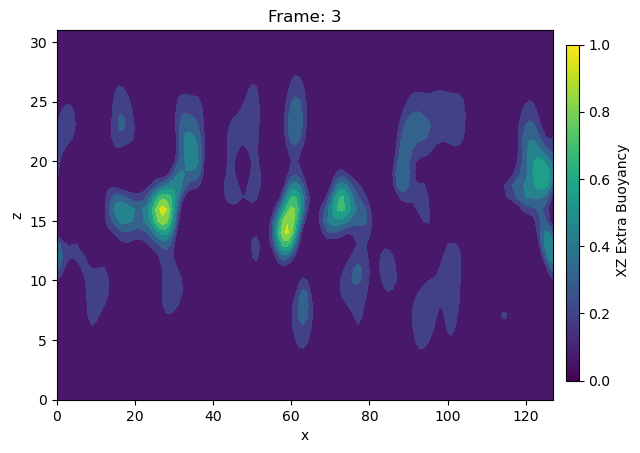

2023-06-14 16:02:08,245 matplotlib.animation 0/1 WARNING :: MovieWriter imagemagick unavailable; using Pillow instead.
2023-06-14 16:02:08,246 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.PillowWriter'>


<Figure size 640x480 with 0 Axes>

In [20]:
files = sorted(glob.glob('snapshots/*.h5'))
with h5py.File(files[0], mode='r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy'][:, :, :, :] 
    dry_buoyancy = file['tasks']['dry buoyancy'][:, :, :, :]
    buoyancy=np.maximum(moist_buoyancy,dry_buoyancy-Vaisala*z)
    extra_buoyancy=buoyancy-(dry_buoyancy-Vaisala*z)
    clouds = np.where(extra_buoyancy < 0, 0, extra_buoyancy)
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        moist_buoyancy = file['tasks']['moist buoyancy'][:, :, :, :] 
        dry_buoyancy = file['tasks']['dry buoyancy'][:, :, :, :]
        buoyancy=np.maximum(moist_buoyancy,dry_buoyancy-Vaisala*z)
        extra_buoyancy=buoyancy-(dry_buoyancy-Vaisala*z)
        cloud = np.where(extra_buoyancy < 0, 0, extra_buoyancy)
        clouds=np.append(clouds,cloud,axis=0)
        
fig, ax = plt.subplots()
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Define colorbar axes position

def animate(frame):
    ax.clear()
    ax.contourf(clouds[frame, :, int(Ny/2), :].T)
    ax.set_title('Frame: {}'.format(frame))
    ax.set_xlabel('x')  # Add x-axis label
    ax.set_ylabel('z')  # Add y-axis label
    vmin = np.min(clouds[frame, :, int(Ny/2), :])
    vmax = np.max(clouds[frame, :, int(Ny/2), :])
    cb = plt.colorbar(ax.collections[0], cax=cax)
    cb.set_label(' XZ Extra Buoyancy')

# Call animate method
animation = FuncAnimation(fig, animate, frames=len(clouds), interval=100, blit=False)
animation.save('XZ_clouds_unstable.gif', writer='imagemagick')
# Display the plot
plt.show()

def animate(frame):
    ax.clear()
    ax.contourf(clouds[frame, :, :, int(3*Nz/4)].T)
    ax.set_title('Frame: {}'.format(frame))
    ax.set_xlabel('x')  # Add x-axis label
    ax.set_ylabel('z')  # Add y-axis label
    vmin = np.min(clouds[frame, :, :, int(3*Nz/4)])
    vmax = np.max(clouds[frame, :, :, int(3*Nz/4)])
    cb = plt.colorbar(ax.collections[0], cax=cax)
    cb.set_label(' XY Extra Buoyancy')

# Call animate method
animation = FuncAnimation(fig, animate, frames=len(clouds), interval=100, blit=False)
animation.save('XY_clouds_unstable.gif', writer='imagemagick')
# Display the plot
plt.show()